# Analyze A/B Test Results 

The current notebook has been organized into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [3]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [8]:
df['converted'].mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [51]:
df_wrong_rows=df.query("group == 'treatment' and landing_page != 'new_page'").shape[0]

1965

**f.** Do any of the rows have missing values?

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


>**No missing value in the dataset.**

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old webpage.  


**a.Store new dataframe in **df2**.

In [11]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df_inaccurate_rows=df.query('group=="treatment" and landing_page == "old_page" or group=="control" and landing_page=="new_page"')
df2 = df.drop(df_inaccurate_rows.index)
df2.shape[0]

290585

In [12]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  

**a.** How many unique **user_id**s are in **df2**?

In [13]:
df2['user_id'].value_counts()

773192    2
630732    1
811737    1
797392    1
795345    1
801490    1
799443    1
787157    1
793302    1
817882    1
842446    1
815835    1
805596    1
803549    1
809694    1
807647    1
895712    1
840399    1
836301    1
899810    1
834242    1
936604    1
934557    1
940702    1
938655    1
830144    1
828097    1
832195    1
838348    1
821956    1
         ..
734668    1
736717    1
730574    1
775632    1
771538    1
642451    1
773587    1
783828    1
785877    1
779734    1
781783    1
759256    1
726472    1
748999    1
746950    1
753093    1
751044    1
740803    1
738754    1
744897    1
742848    1
634271    1
632222    1
636316    1
630169    1
650647    1
648598    1
654741    1
652692    1
630836    1
Name: user_id, Length: 290584, dtype: int64

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2.query('user_id=="773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [15]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2= df2.drop([df2.index[2893]])
# Check again if the row with a duplicate user_id is deleted or not
df2.shape[0]

290584

>**The df2 dataframe is reduced to 290584 observations.**

### ToDo 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>


In [16]:
p_population= df2['converted'].mean()
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p_control= df2.query('group=="control"')['converted'].mean()
p_control

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p_treatment= df2.query('group=="treatment"')['converted'].mean()
p_treatment 

0.11880806551510564

In [19]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups by 3 different approaches:
obs_diff=p_treatment -p_control
obs_diff

-0.0015782389853555567

In [20]:
# The second approach
p_by_group=df2.groupby('group')['converted'].mean()
obs_diff=p_by_group[1]-p_by_group[0]
obs_diff

-0.0015782389853555567

In [21]:
# The third approach
obs_diff = df2[df2['group']=='treatment']['converted'].mean() - df2[df2['group']=='control']['converted'].mean()
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [22]:
df2.query('landing_page=="new_page"').shape[0]/df2.shape[0]

0.5000619442226688

**e.** Consider the results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**It seems that the new treatment group users doesn't lead to more conversions.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, we could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider we need to make the decision just based on all the data provided.  

If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be our null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

Our hypothesis is stated as follows in which **$p_{old}$** and **$p_{new}$** are the "converted" probability (or rate) for the old and new pages respectively.

<center>
$H_0$ : $p_{new}$ <= $p_{old}$
<br><br>
$H_1$ : $p_{new}$ > $p_{old}$
</center>

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

<center>
$p_{new}$ = $p_{old}$ = $p_{population}$ = 0.1196
</center>

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

<center>
$p_{new}$ = $p_{old}$ = $p_{population}$ = 0.1196
</center>

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [23]:
n_new = df2.query("landing_page == 'new_page'").shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis. Store these $n_{old}$ 1's and 0's in the `new_page_converted` numpy array.  <br><br>


In [25]:
# Simulate a Sample for the treatment Group
p_new=0.1196
new_page_converted=np.random.choice([0,1],n_new,p=[1-p_new,p_new])
new_page_converted.mean()

0.11973711375679581

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [26]:
# Simulate a Sample for the control Group
p_old=0.1196
old_page_converted=np.random.choice([0,1],n_old,p=[1-p_old,p_old])
old_page_converted.mean()

0.12048955766344975

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for our simulated samples from the parts (e) and (f) above. 

In [27]:
difference_sampled=new_page_converted.mean()-old_page_converted.mean()
difference_sampled

-0.0007524439066539379


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process we used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [45]:
# Sampling distribution 
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new 
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old 
p_diffs = new_converted_simulation - old_converted_simulation

**i. Histogram**<br> 
Plot a histogram of the **p_diffs** which seems to be normally distributed.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed `obs_diff` in the `df2` data, in the chart.  

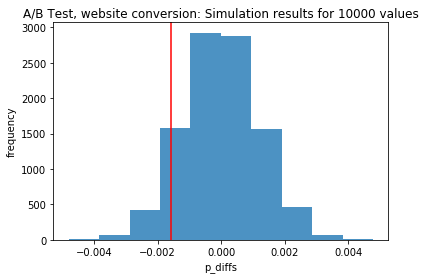

In [29]:
#histogram for the bootstrap sample and the obs_diff
p_diffs = np.array(p_diffs)
plt.hist(p_diffs, alpha = 0.8)
plt.title('A/B Test, website conversion: Simulation results for 10000 values',fontsize=12)
plt.ylabel('frequency')
plt.xlabel('p_diffs')
plt.axvline(x=obs_diff,color='red');

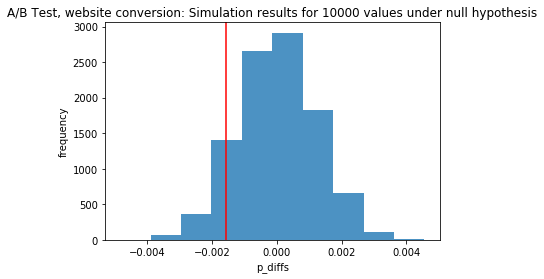

In [30]:
# Create null vals of normal distribution with mean = 0 and standard deviation = p_diffs's std.
null_vals = np.random.normal(0,p_diffs.std(),p_diffs.size)
#histogram for the null
plt.hist(null_vals,alpha=0.8)
plt.title('A/B Test, website conversion: Simulation results for 10000 values under null hypothesis',fontsize=12)
plt.ylabel('frequency')
plt.xlabel('p_diffs')
plt.axvline(x=obs_diff, color='red');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [31]:
(null_vals > obs_diff).mean()

0.90839999999999999

**k.** Explain in words what we have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages?

>**p_value under null hypothesis is 0.905. This suggests that there is no difference between the new and old pages since we can not reject $H_0$ at Type I error rate (0.05).**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [32]:
import statsmodels.api as sm
from pandas.core import datetools
# number of conversions with the old_page
convert_old = df2.query("landing_page == 'old_page'").converted.sum()

# number of conversions with the new_page
convert_new = df2.query("landing_page == 'new_page'").converted.sum()

# number of individuals who were shown the old_page
n_old = df2.query("landing_page == 'old_page'").shape[0]

# number of individuals who received new_page
n_new = df2.query("landing_page == 'new_page'").shape[0]

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

In [33]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
count_array = np.array([convert_new, convert_old])

nobs_array = np.array([n_new, n_old])

z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative ='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

**n.** What do the z-score and p-value we computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Because the z_score is found to be below the z_alpha=1.64 for a confidence interval of 95%, we fail to reject the null hypothesis.**

>**The z-score and p-value in this z test is consistent with the findings of sampling distribution which suggests that there is no difference between the conversion rates of the old and new pages.**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should we be performing in this case?

>**Since each row in the df2 data is either a conversion or no conversion, we should perform logistic regression in this case.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, we first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [34]:
#dummy variable column ab_page for either treatment or control group
df2[['control','treatment']]= pd.get_dummies(df2['group'])
df2=df2.drop('control', axis=1)
df2.rename(columns = {'treatment':'ab_page'}, inplace = True)
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


In [35]:
# create intercept column
df2['intercept']=1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


**c.** Use **statsmodels** to instantiate our regression model on the two columns we created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [36]:
import statsmodels.api as sm
logit_mod=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result=logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-05-04 06:18 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value we found in **Part II**?<br><br>  

>**With the regression model, we set up the two-sided test while tests in Part II of A/B Test are one-tailed tests. The null hypothesis associated with our regression model is that changing to the new page has zero effect on conversion. Accordingly, the alternative hypothesis is that there is the relationship berween website page and conversion rate.** 

> **In our regression model's result, the p-value associated with ab_page is 0.1899 which indicates that the chance of conversion is no more different between treatment and control group.**

**f.** Now, we are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into our regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**It is a good idea to consider other factors, for example, which country a user lives in to add into our regression model. The reason is because there may be other factors affecting whether or not an individual converts other than different pages.**

>**One of the disadvantages to adding additional terms into your regression model is that it is more complicated to explain the finding results and that we need to collect or add more data to the current dataset.**

>**Furthermore, a common problem of adding many parameters into the regression model is multicollinearity. Multicollinearity occurs when two or more parameters are collinear with each other.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. Read in the **countries.csv** dataset and merge together our `df2` datasets on the appropriate rows which results in dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

In [38]:
# Read the countries.csv
df_country = pd.read_csv("./countries.csv")

In [39]:
# Join with the df2 dataframe on user_id 
df_merged=df2.join(df_country.set_index('user_id'), on='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [40]:
# Create the necessary dummy variables
df_merged[['CA','UK','US']]= pd.get_dummies(df_merged['country'])
df_merged=df_merged.drop('US', axis=1)

In [46]:
# Look at the effect of country on conversion 
logit_mod_country=sm.Logit(df_merged['converted'],df_merged[['intercept','ab_page','CA','UK']])
result_2=logit_mod_country.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [47]:
result_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-05-04 06:26 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

>**Similary to the p-value associated with ab_page, country individually does not seem to have any effects on conversion with the Type I error rate (0.05).**

**h. Fit our model and obtain the results**<br> 
Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 

In [48]:
# Create new column to capture the interaction between the page and the country
df_merged['ab_UK'] = df_merged['ab_page'] * df_merged['UK']
df_merged['ab_CA'] = df_merged['ab_page'] * df_merged['CA']

In [49]:
# Fit our model, and summarize the results
logit_mod_both_factors=sm.Logit(df_merged['converted'],df_merged[['intercept','ab_page','CA','UK','ab_CA','ab_UK']])
result_3=logit_mod_both_factors.fit()
result_3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-05-04 06:30 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_CA        -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
ab_UK         0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

>**We get negative z-score which is consistent with the negative actual difference (-0.0015).**

>**The interaction between the country and page does not provide us any significant benefit regarding new user conversions.**

>**Neither website page nor country where user live has statistically significant relationships with the conversion rate in our logistic regression model at Type I error rate (0.05). This means we do fail to reject the null hypotheses of our logistic regression model.**

>**The old page should be good for now. We need to run the test longer to make decision whether page or country have statistically significant effects on the conversion. We can always make another experiment in the future if the circumstances change.**